#Viewing finetuning curves

###Mount drive and Authenticate for GCP & Copy tfevents from GCS into drive

In [ ]:
from google.colab import auth,drive
print("Mount drive:")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH="/content/drive/My Drive"
import os
print("Authenticate for GCS:")
auth.authenticate_user()

BUCKET_NAME = "theodore_jiang" #@param{type:"string"}
TFEVENTs_DESTINATION_PATH = "/content/drive/My Drive" #@param{type:"string"}

runs = ["mrpc_loss_spam_model_comparison_final",
        "re_loss_spam_model_comparison_final",
        "ner_loss_spam_model_comparison_final"]

for run in runs: ##This will copy all of the tfevent files from GCS into drive, and will also delete all of the files from GCS
  cmd = "gsutil -m cp -r \"gs://"+BUCKET_NAME+"/"+run+"\" \""+TFEVENTs_DESTINATION_PATH+"\""
  !{cmd}
  cmd = "gsutil -m rm -r "+"\"gs://"+BUCKET_NAME+"/"+run+"\""
  !{cmd}

  

###Just mount drive (use this if you wish to only use existing tfevent files from drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH = "/content/drive/My Drive"
TFEVENTs_DESTINATION_PATH = "/content/drive/My Drive" #@param{type:"string"}

###Obtain events from tfevents for finetuning graphs


In [ ]:
import os
import numpy as np
import pandas as pd
import json
from tqdm import tqdm

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

runs = ["mrpc_loss_spam_model_comparison_final",
        "re_loss_spam_model_comparison_final",
        "ner_loss_spam_model_comparison_final"]

#@markdown ######only the (skip)-th tfevent file will be considered (useful when amount of tfevent files is more than what is necessary for viewing curves) (if no tfevents should be skipped, set to 1)
skip = 500 #@param {type:"integer"}

def tabulate_events(dpath,out_dict = {}):
    for dname in tqdm(os.listdir(dpath),"converting to dict"):
        if "tfevents" not in dname:
          continue
        ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
        tags = ea.Tags()['scalars']

        for tag in tags:
            tag_values=[]
            wall_time=[]
            steps=[]

            for event in ea.Scalars(tag):
                 if event.step%skip==0 or "eval" in tag:
                    try:
                        out_dict[tag].append((event.step,event.value))
                    except:
                        out_dict[tag] = [(event.step,event.value)]
    return out_dict

graph_data = {}

for run in runs:
    for subrun in os.listdir("/content/drive/My Drive/"+run):
      if "predictions" in subrun:
        continue
      data = tabulate_events("/content/drive/My Drive/"+run+"/"+subrun)
      print(subrun,subrun.count("_"))
      for metric,datapoints in tqdm(data.items(),run+"_"+subrun):
          try:
              graph_data[metric][run+"-"+subrun].append(datapoints)
          except:
              try:
                  graph_data[metric][subrun] = [datapoints]
              except:
                  graph_data[metric] = {}
                  graph_data[metric][subrun] = [datapoints]



###Plotting smoothed average curves using matplotlib

In [ ]:
import matplotlib.pyplot as plt
import math
import re

#@markdown range of the local average for viewing training graphs (to disable local averaging, set it to 0)
avg_range = 100 #@param {type:"integer"}
#@markdown destination path for saving graphs (for no saving set to None)
outfolder = DRIVE_PATH+"/training graphs" #@param

if not os.path.exists(outfolder):
  os.makedirs(outfolder)

for metric,runs in graph_data.items():
    if "rando" in metric:
      continue
    plt.figure(figsize=(10,5))
    plt.title(metric+" graph")
    plt.xlabel("steps")
    plt.ylabel(metric)
    for run,run_data in runs.items():
        run_data = run_data[0]
        steps = []
        values = []
        nan = 0
        for datapt in run_data:
            if not math.isnan(datapt[1]):
                values.append(datapt[1])
                steps.append(datapt[0])
            else:
                nan+=1
        print("nan values:",nan)
        values = [x for _, x in sorted(zip(steps, values), key=lambda pair: pair[0])]

        if "eval" in metric or avg_range == 0:
          avged_values = values
        else:
          avged_values = [sum(values[max(n-avg_range,0):min(n+avg_range,len(values))])/len(values[max(n-avg_range,0):min(n+avg_range,len(values))]) for n,value in enumerate(values)]
        steps = sorted(steps)
        plt.plot(steps,avged_values,label=run)
                
    plt.legend()
    if outfolder:
      plt.savefig(outfolder+"/"+metric.replace("/","_")+".png")
    plt.show()


###Tensorboard viewing (If you wish to use tensorboard instead)

In [ ]:
LOGS_DIR = "/content/drive/My Drive" #@param (type:"string")
LOGS_DIR = "\""+LOGS_DIR+"\""
%load_ext tensorboard
%tensorboard --logdir $LOGS_DIR

#Predictions Processing

###Download prediction files from GCS (if used EVALUATE_WHILE_PREDICT)

In [ ]:
from google.colab import auth,drive
print("Mount drive:")
drive.mount('/content/drive', force_remount=True)
DRIVE_PATH="/content/drive/My Drive"
import os
print("Authenticate for GCS:")
auth.authenticate_user()

BUCKET_NAME = "theodore_jiang" #@param{type:"string"}
#@markdown where to download the tfevent files into
TFEVENTs_DESTINATION_PATH = "/content/drive/My Drive" #@param{type:"string"}

runs = ["ner_loss_spam_model_comparison_final_predictions",
        "mrpc_loss_spam_model_comparison_final_predictions"]

for run in runs[1:]: ##This will copy all of the tfevent files from GCS into drive, and will also delete all of the files from GCS
  cmd = "gsutil -m cp -r \"gs://"+BUCKET_NAME+"/"+run+"\" \""+TFEVENTs_DESTINATION_PATH+"\""
  !{cmd}
  cmd = "gsutil -m rm -r "+"\"gs://"+BUCKET_NAME+"/"+run+"\""
  !{cmd}

  

###Convert tfevents into txts (if used EVALUATE_WHILE_PREDICT)

In [ ]:
import os
from tqdm import tqdm
import re

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

runs = ["ner_loss_spam_model_comparison_final_predictions",
        "mrpc_loss_spam_model_comparison_final_predictions"]


def tabulate_events(dpath):
    out_dict = {}
    stepsa = []
    for dname in os.listdir(dpath):
      if "tfevents" not in dname:
        continue
      ea = EventAccumulator(os.path.join(dpath, dname)).Reload()
      tags = ea.Tags()['scalars']

      out = {}

      for tag in tags:
          steps=[]
          
          for event in ea.Scalars(tag):
            if not event.step in steps:
              steps.append(event.step)

          for n,event in enumerate(ea.Scalars(tag)):
            if event.step not in stepsa:
              stepsa.append(event.step)
            try:
                out_dict[tag].append((event.value,n,event.step))
            except:
                out_dict[tag] = [(event.value,n,event.step)]
    return out_dict

graph_data = {}

for run in runs:
    for subrun in os.listdir(TFEVENTs_DESTINATION_PATH+"/"+run):
      if not os.path.isdir(TFEVENTs_DESTINATION_PATH+"/"+run+"/"+subrun):
        continue
      data = tabulate_events(TFEVENTs_DESTINATION_PATH+"/"+run+"/"+subrun)
      data_polished = {}
      for k,v in data.items():
        key=re.sub("\_\d+$","",k)
        for value in v:
          try:
            data_polished[key].append(value)
          except:
            data_polished[key] = [value]
      pred_probs = [x[0] for x in sorted(sorted(list(data_polished["probability"]),key=lambda x:x[2]),key=lambda x:x[1])]
      labels = [x[0] for x in sorted(sorted(list(data_polished["label"]),key=lambda x:x[2]),key=lambda x:x[1])]
      input_ids = [x[0] for x in sorted(sorted(list(data_polished["input_id"]),key=lambda x:x[2]),key=lambda x:x[1])]

      pred_probs = pred_probs[:min(len(input_ids),len(labels),len(pred_probs))]
      labels = labels[:min(len(input_ids),len(labels),len(pred_probs))]
      input_ids = input_ids[:min(len(input_ids),len(labels),len(pred_probs))]

      with open(TFEVENTs_DESTINATION_PATH+"/"+run+"/"+subrun+"_predictions.txt","w+") as out:
        for n,prob in enumerate(tqdm(pred_probs,run+"_"+subrun)):
          out.write("probabilities:"+str(prob)+"\t"+
                    "labels:"+str(labels[n])+"\t"+
                    "input_ids:"+str(input_ids[n])+"\n")

###Just Mount drive (if not used EVALUATE_WHILE_PREDICT)

In [ ]:
from google.colab import drive,auth
import os
import shutil
!fusermount -u /content/drive
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)
TFEVENTs_DESTINATION_PATH = "/content/drive/My Drive"
DRIVE_PATH = "/content/drive/My Drive"

###Plot ROC Curves using txts

Stats for: NER_bert_model_ner_final_modified_256_32_predictions.txt 

list index out of range  32880
tp: 1383 tn: 24501 fp: 1057 fn: 5939
acc: 0.7872262773722628
recall_total: 0.18888281890193936
precision_total: 0.5668032786885245
f1_total: 0.28334357713583286 

Stats for: NER_bert_model_ner_final_modified_512_32_predictions.txt 

list index out of range  33168
tp: 800 tn: 25765 fp: 462 fn: 6141
acc: 0.8009225759768451
recall_total: 0.11525716755510733
precision_total: 0.6339144215530903
f1_total: 0.19505059124710475 

Stats for: NER_bert_model_ner_final_modified_1024_32_predictions.txt 

list index out of range  33408
tp: 333 tn: 25645 fp: 219 fn: 7211
acc: 0.7775981800766284
recall_total: 0.04414103923647932
precision_total: 0.6032608695652174
f1_total: 0.08226284584980238 

Stats for: NER_bert_model_ner_final_modified_256_64_predictions.txt 

list index out of range  32880
tp: 2298 tn: 23829 fp: 1729 fn: 5024
acc: 0.7946167883211679
recall_total: 0.31384867522534826
precision_total

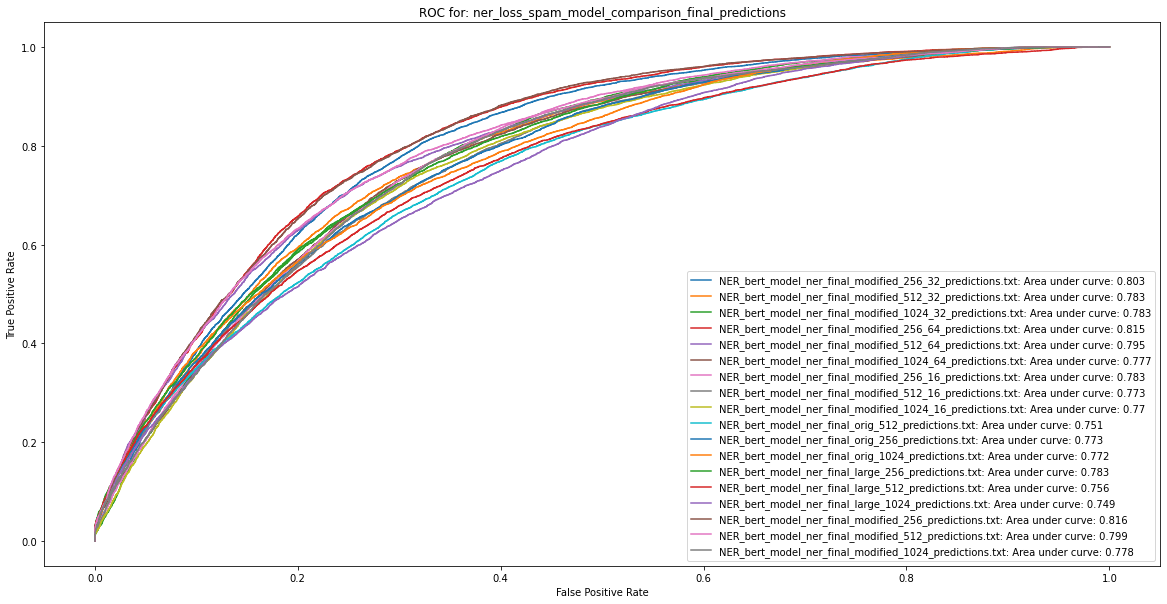

Stats for: MRPC_bert_model_mrpc_modified_medium_256_predictions.txt 

list index out of range  15360
tp: 5435 tn: 7719 fp: 962 fn: 1244
acc: 0.8563802083333333
recall_total: 0.8137445725407996
precision_total: 0.8496170079724871
f1_total: 0.8312939736922607 

Stats for: MRPC_bert_model_mrpc_modified_medium_512_predictions.txt 

list index out of range  15360
tp: 5390 tn: 7938 fp: 661 fn: 1371
acc: 0.8677083333333333
recall_total: 0.7972193462505547
precision_total: 0.8907618575442076
f1_total: 0.8413986887293163 

Stats for: MRPC_bert_model_mrpc_modified_medium_1024_predictions.txt 

list index out of range  14336
tp: 3688 tn: 7524 fp: 467 fn: 2657
acc: 0.7820870535714286
recall_total: 0.5812450748620961
precision_total: 0.8876052948255114
f1_total: 0.7024761904761905 

Stats for: MRPC_bert_model_mrpc_modified_large_256_predictions.txt 

list index out of range  15360
tp: 5445 tn: 7735 fp: 946 fn: 1234
acc: 0.8580729166666666
recall_total: 0.8152418026650696
precision_total: 0.85197934

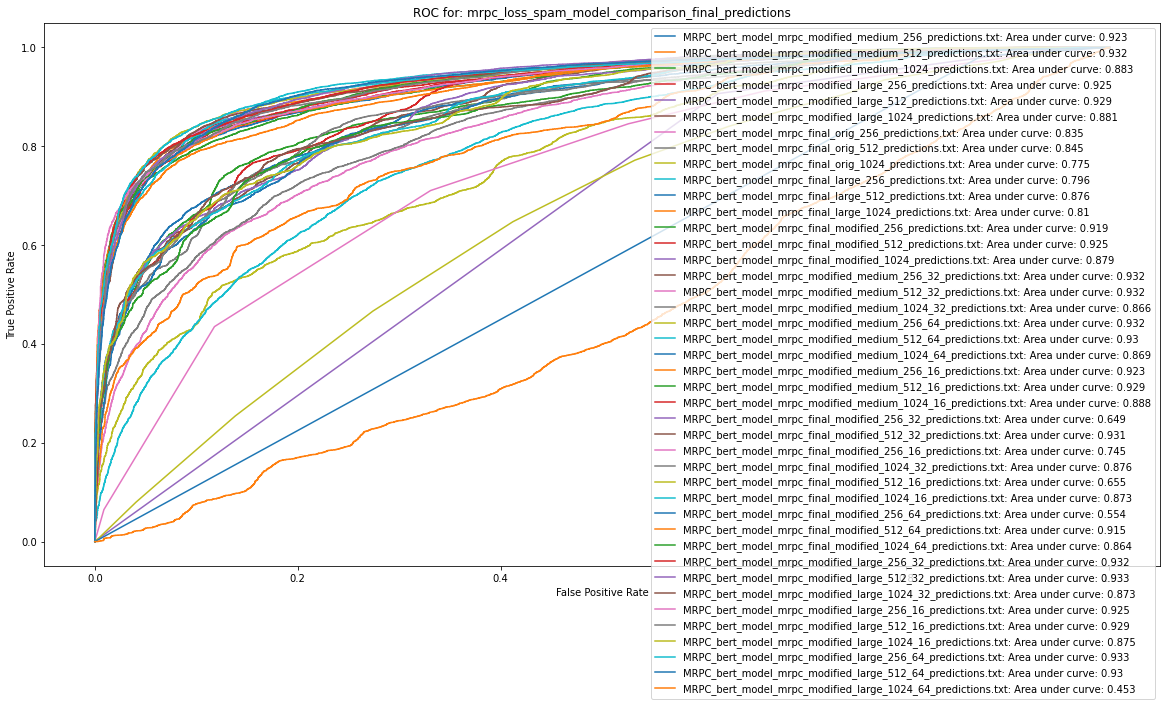

Stats for: RE_bert_model_re_final_orig_256_predictions.txt 

list index out of range  32960
tp: 95 tn: 25893 fp: 101 fn: 6871
acc: 0.7884708737864078
recall_total: 0.013637668676428367
precision_total: 0.4846938775510204
f1_total: 0.026528902541189614 

Stats for: RE_bert_model_re_final_orig_512_predictions.txt 

list index out of range  33376
tp: 258 tn: 26330 fp: 298 fn: 6490
acc: 0.7966203259827421
recall_total: 0.038233550681683465
precision_total: 0.46402877697841727
f1_total: 0.07064622124863089 

Stats for: RE_bert_model_re_final_orig_1024_predictions.txt 

list index out of range  33136
tp: 651 tn: 24784 fp: 825 fn: 6876
acc: 0.7675941574118783
recall_total: 0.08648864089278598
precision_total: 0.4410569105691057
f1_total: 0.14461846051316227 

Stats for: RE_bert_model_re_final_large_256_predictions.txt 

list index out of range  32960
tp: 117 tn: 25865 fp: 129 fn: 6849
acc: 0.7882888349514563
recall_total: 0.016795865633074936
precision_total: 0.47560975609756095
f1_total: 0.0

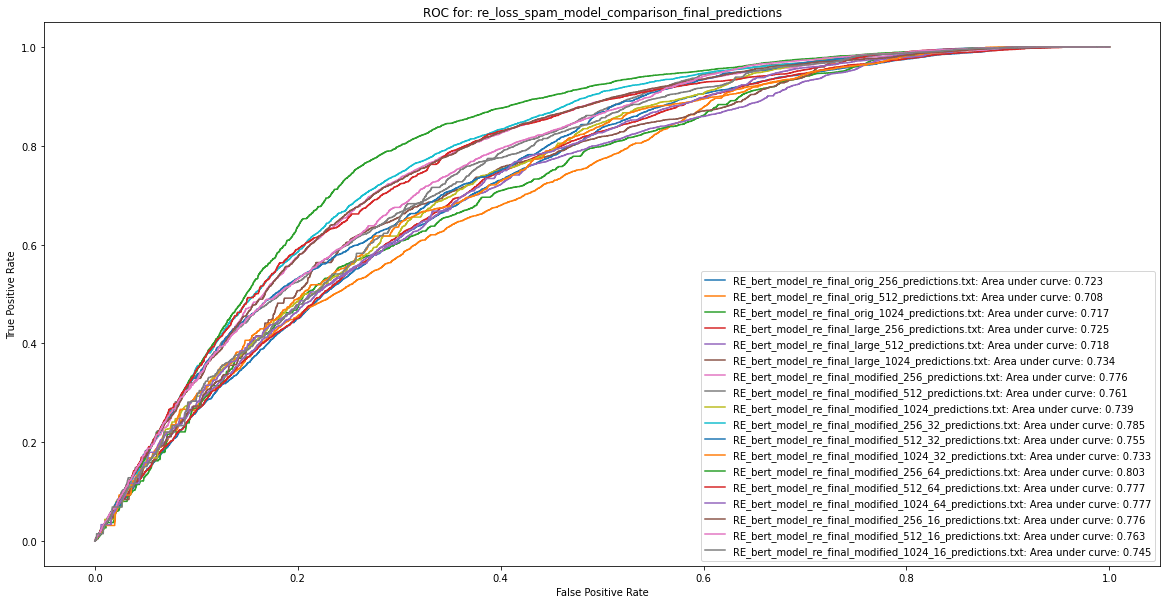

Printing all AUCs...
model: MRPC_bert_model_mrpc_modified_large_1024_64_predictions.txt 	AUC: 0.453
model: MRPC_bert_model_mrpc_final_modified_256_64_predictions.txt 	AUC: 0.554
model: MRPC_bert_model_mrpc_final_modified_256_32_predictions.txt 	AUC: 0.649
model: MRPC_bert_model_mrpc_final_modified_512_16_predictions.txt 	AUC: 0.655
model: RE_bert_model_re_final_orig_512_predictions.txt 	AUC: 0.708
model: RE_bert_model_re_final_orig_1024_predictions.txt 	AUC: 0.717
model: RE_bert_model_re_final_large_512_predictions.txt 	AUC: 0.718
model: RE_bert_model_re_final_orig_256_predictions.txt 	AUC: 0.723
model: RE_bert_model_re_final_large_256_predictions.txt 	AUC: 0.725
model: RE_bert_model_re_final_modified_1024_32_predictions.txt 	AUC: 0.733
model: RE_bert_model_re_final_large_1024_predictions.txt 	AUC: 0.734
model: RE_bert_model_re_final_modified_1024_predictions.txt 	AUC: 0.739
model: MRPC_bert_model_mrpc_final_modified_256_16_predictions.txt 	AUC: 0.745
model: RE_bert_model_re_final_modi

In [ ]:
from tqdm import tqdm
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

runs = ["ner_loss_spam_model_comparison_final_predictions",  ## where the predictions were stored (should match up with 
        "mrpc_loss_spam_model_comparison_final_predictions",
        "re_loss_spam_model_comparison_final_predictions"]  ## the PREDICTIONS_FOLDER parameter in the eval script)
#@markdown destination path for saving ROC curves (for no saving set to None)
outfolder = DRIVE_PATH+"/ROC curves final" #@param
if outfolder and not os.path.exists(outfolder):
  os.makedirs(outfolder)

AUCs = {}
for run in runs:
  plt.figure(figsize=(20,10))
  for subrun in os.listdir(TFEVENTs_DESTINATION_PATH+"/"+run):
    
    labels = []
    pred_probs = []
    tp=0
    tn=0
    fp=0
    fn=0
    if os.path.isdir(TFEVENTs_DESTINATION_PATH+"/"+run+"/"+subrun):
      continue
    print("Stats for:",subrun,"\n")

    for n,line in enumerate(open(TFEVENTs_DESTINATION_PATH+"/"+run+"/"+subrun).read().split("\n")):
      line_dict = {}
      try:
        for item in line.split("\t"):
            line_dict[item.split(":")[0]] = item.split(":")[1]
        label = float(line_dict["labels"])
        pred = float(line_dict["probabilities"])
        pred_probs.append(pred)
        labels.append(label)
        if label == 1 and pred>0.5:
          tp+=1
        elif label == 0 and pred<0.5:
          tn+=1
        elif label == 0 and pred>0.5:
          fp+=1
        elif label == 1 and pred<0.5:
          fn+=1
      except Exception as e:
        print(e,line,n)
        continue

    try:
      acc = (tp+tn)/(tp+tn+fp+fn)
      recall = tp/(tp+fn)
      precision = tp/(tp+fp)
      f1 = 2*precision*recall/(precision+recall)
      pred_auc = roc_auc_score(labels, pred_probs)
    except:
      pass

    print("tp:",tp,
          "tn:",tn,
          "fp:",fp,
          "fn:",fn)
    print("acc:",acc)
    print("recall_total:",recall)
    print("precision_total:",precision)
    print("f1_total:",f1,"\n")

    # summarize scores
    # calculate roc curves
    pred_fpr, pred_tpr, _ = roc_curve(labels, pred_probs)
    # plot the roc curve for the model
    plt.plot(pred_fpr, pred_tpr, linestyle="-", label=subrun+': Area under curve: '+str(round(pred_auc,3)))
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    AUCs[subrun] = round(pred_auc,3)
  plt.title("ROC for: "+run)
  if outfolder:
      plt.savefig(outfolder+"/"+run.replace(".txt",".png"))
  plt.show()

AUCs = {k:v for k,v in sorted([(k,v) for k,v in AUCs.items()],key=lambda x:x[1])}
print("Printing all AUCs...")
for k,v in AUCs.items():
  print("model:",k,"\tAUC:",v)